# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import numpy as np
import re

from datetime import datetime

In [2]:
data = pd.read_csv('main_task.csv')

# Restaurant_id — идентификационный номер ресторана / сети ресторанов;
# City — город, в котором находится ресторан;
# Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
# Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
# Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
# Price Range — диапазон цен в ресторане;
# Number of Reviews — количество отзывов о ресторане;
# Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
# URL_TA — URL страницы ресторана на TripAdvisor;
# ID_TA — идентификатор ресторана в базе данных TripAdvisor.

data.head(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


## Смотрим информацию о датасете

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [4]:
data.describe()

,Ranking,Rating,Number of Reviews
count,40000.000000,40000.000000,37457.000000
mean,3676.028525,3.993037,124.825480
std,3708.749567,0.668417,295.666352
min,1.000000,1.000000,2.000000
25%,973.000000,3.500000,9.000000
50%,2285.000000,4.000000,33.000000
75%,5260.000000,4.500000,115.000000
max,16444.000000,5.000000,9660.000000


## Работаем с разнообразием кухонь

Здесь достаём их из списка, который находится в столбце "Cuisine Style"

In [5]:
def split_cuisines(cuisines:str) -> str:
    cui_list = list()
    for cui in re.findall("(?<=')[\w\s]+", cuisines):
        cui_list.append(cui)
    return '|'.join(cui_list)

Создаем отдельный столбец для преобразованных данных

In [6]:
data['Cuisines list'] = data['Cuisine Style'].dropna().apply(split_cuisines)

В следующий столбец запишем кол-во кухонь представленных в ресторане

In [7]:
data['Cuisines amount'] = data['Cuisines list'].dropna().apply(lambda x: len(str(x).split('|')))
data['Cuisines amount'] = data['Cuisines amount'].fillna(1)

Применим get_dummies для создания дополнительных 125 столбцов по кол-ву возможных кухонь.

In [8]:
data = data.join(data['Cuisines list'].str.get_dummies(sep='|'))

In [9]:
cuisines_cols = data.columns[9:]

In [10]:
count_cuisines = dict()
for col in cuisines_cols:
    count_cuisines[col] = data.loc[data[col] == 1, [col]].count()[0]

pd.Series(count_cuisines).sort_values(ascending=False).head()

Cuisines amount        16547
Vegetarian Friendly    11189
European               10060
Mediterranean           6277
Italian                 5964
dtype: int64

## Преобразуем признаки по ценам

In [11]:
data['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [12]:
def fix_price_range(dollars):
    if dollars == '$':
        return 1
    elif dollars == '$$$$':
        return 3
    else:
        return 2

In [13]:
data['Price Range'] = data['Price Range'].dropna().apply(fix_price_range)

Заполним пропуски самым часто встречающимся значением

In [14]:
data['Price Range'] = data['Price Range'].fillna(2)

## Обрабатываем города

Добавим города, используя get_dummies

In [15]:
data = data.join(pd.get_dummies(data['City']))

Добавим также через метод get_dummies и страны, соответствующие каждому городу

In [16]:
countries_info = {
    'London': ['England', 8982000],
    'Paris': ['France', 2161000],
    'Madrid': ['Spain', 3223000],
    'Barcelona': ['Spain', 1620000],
    'Berlin': ['Germany', 3645000],
    'Milan': ['Italy', 1352000],
    'Rome': ['Italy', 2873000],
    'Prague': ['Czech', 1309000],
    'Lisbon': ['Portugal', 504718],
    'Vienna': ['Austria', 1897000],
    'Amsterdam': ['Netherlands', 821752],
    'Brussels': ['Belgium', 2081000],
    'Hamburg': ['Germany', 1841000],
    'Munich': ['Germany', 1472000],
    'Lyon': ['France', 1719000],
    'Stockholm': ['Sweden', 975551],
    'Budapest': ['Hungary', 1768000],
    'Warsaw': ['Poland', 1800000],
    'Dublin': ['Ireland', 1420000],
    'Copenhagen': ['Denmark', 1346000],
    'Athens': ['Greece', 3153000],
    'Edinburgh': ['Scotland', 537000],
    'Zurich': ['Switzerland', 1395000],
    'Oporto': ['Portugal', 1313000],
    'Geneva': ['Switzerland', 613000],
    'Krakow': ['Poland', 769000],
    'Oslo': ['Norway', 697549],
    'Helsinki': ['Finland', 1305000],
    'Bratislava': ['Slovakia', 440948],
    'Luxembourg': ['Luxembourg', 626000],
    'Ljubljana': ['Slovenia', 2084301],
}

In [17]:
data['Country'] = data['City'].apply(lambda x: '_' + countries_info[x][0])
data['Population'] = data['City'].apply(lambda x: countries_info[x][1])

In [18]:
data = data.join(pd.get_dummies(data['Country']))

## Нормализуем ранк ресторана

Найдем по городу все рестораны и нормализуем их значения, чтобы между городами и странами не было такого различия.

In [19]:
def pop_rank(row):
    rank = row['Ranking']
    pop = countries_info[row['City']][1]
    return pop / rank

In [20]:
data['Population rank'] = data.apply(pop_rank, axis=1)

In [21]:
def normalize_ranking(row):
    max_id = data.loc[data['City'] == row['City'], 'Ranking'].max()
    return row.Ranking / max_id

In [22]:
data['Normd city ranking'] = data.apply(normalize_ranking, axis=1)

## Работаем с датами отзывов

Сначала получим раннюю из двух дат

In [23]:
def convert_dt(line):
    dd = re.compile('\d{2}/\d{2}/\d{4}')
    dates = dd.findall(line)
    if not dates:
        return None
    dlist = list()
    for date in dates:
        dlist.append(datetime.strptime(date, '%m/%d/%Y'))
    if len(dlist) > 1:
        return min(dlist)
    else:
        return None

In [24]:
data['Prev review date'] = data['Reviews'].dropna().apply(convert_dt)

А теперь дату последнего обзора

In [25]:
def convert_dt(line):
    dd = re.compile('\d{2}/\d{2}/\d{4}')
    dates = dd.findall(line)
    if not dates:
        return None
    dlist = list()
    for date in dates:
        dlist.append(datetime.strptime(date, '%m/%d/%Y'))
    return max(dlist)

In [26]:
data['Recent review date'] = data['Reviews'].dropna().apply(convert_dt)

Посчитаем разницу в днях между двумя датами

In [27]:
def count_days(line):
    dd = re.compile('\d{2}/\d{2}/\d{4}')
    dates = dd.findall(line)
    if not dates:
        return None
    dlist = list()
    for date in dates:
        dlist.append(datetime.strptime(date, '%m/%d/%Y'))
    if len(dlist) == 2:
        diff = max(dlist) - min(dlist)
        return diff.days
    else:
        return None

In [28]:
data['Review days gap'] = data['Reviews'].dropna().apply(count_days)

In [29]:
data[['Review days gap']].describe()

,Review days gap
count,28973.000000
mean,141.712180
std,221.165893
min,0.000000
25%,20.000000
50%,67.000000
75%,173.000000
max,3207.000000


Посмотрим топ самых больших значений разницы между обзорами.

In [30]:
data.loc[data['Review days gap'] > 0, ['Prev review date', 'Recent review date', 'Review days gap']].sort_values(by='Review days gap').tail()

,Prev review date,Recent review date,Review days gap
19438,2008-10-25,2017-04-15,3094.0
8356,2008-01-06,2016-06-28,3096.0
39997,2008-04-12,2016-11-03,3127.0
10997,2008-03-25,2016-10-26,3137.0
7990,2007-12-22,2016-10-02,3207.0


Заполним 'Review days gap' средним значением по городу.

In [31]:
data['Review days gap'].fillna(-1, inplace=True)

In [32]:
def mean_gap(row):
    if row['Review days gap'] < 0:
        mean_value = data.loc[data['City'] == row['City'], 'Review days gap'].mean()
        return mean_value
    else:
        return row['Review days gap']

In [33]:
data['Review days gap'] = data.apply(mean_gap, axis=1)

In [34]:
data['Review days gap']

0          41.000000
1         382.000000
2           2.000000
3         122.463109
4         272.000000
            ...     
39995      34.000000
39996       9.000000
39997    3127.000000
39998      23.000000
39999    1306.000000
Name: Review days gap, Length: 40000, dtype: float64

## Попробуем создать новые признаки с помощью PolynomialFeatures

In [35]:
data['Number of Reviews'] = data['Number of Reviews'].fillna(0)

In [36]:
data[list(data.columns[:9]) + list(data.columns[134:137]) + list(data.columns[192:])].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Restaurant_id       40000 non-null  object        
 1   City                40000 non-null  object        
 2   Cuisine Style       30717 non-null  object        
 3   Ranking             40000 non-null  float64       
 4   Rating              40000 non-null  float64       
 5   Price Range         40000 non-null  float64       
 6   Number of Reviews   40000 non-null  float64       
 7   Reviews             40000 non-null  object        
 8   URL_TA              40000 non-null  object        
 9   Wine Bar            40000 non-null  int64         
 10  Xinjiang            40000 non-null  int64         
 11  Yunnan              40000 non-null  int64         
 12  _Switzerland        40000 non-null  uint8         
 13  Population rank     40000 non-null  float64   

In [37]:
# data.drop([x for x in range(20)], axis=1, inplace=True)

In [38]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(data[['Review days gap', 'Number of Reviews', 'Population']])
poly_features.shape

poly_features_df = pd.DataFrame(poly_features)
data = data.join(poly_features_df)

# Оценим показатели корреляций

In [39]:
new_cols = list(data.columns[:9]) + list(data.columns[134:137]) + list(data.columns[168:170]) + list(data.columns[-25:])
new_cols

['Restaurant_id',
 'City',
 'Cuisine Style',
 'Ranking',
 'Rating',
 'Price Range',
 'Number of Reviews',
 'Reviews',
 'URL_TA',
 'Wine Bar',
 'Xinjiang',
 'Yunnan',
 'Country',
 'Population',
 '_Netherlands',
 '_Norway',
 '_Poland',
 '_Portugal',
 '_Scotland',
 '_Slovakia',
 '_Slovenia',
 '_Spain',
 '_Sweden',
 '_Switzerland',
 'Population rank',
 'Normd city ranking',
 'Prev review date',
 'Recent review date',
 'Review days gap',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9]

In [40]:
data[new_cols].corr()

,Ranking,Rating,Price Range,Number of Reviews,Wine Bar,Xinjiang,Yunnan,Population,_Netherlands,_Norway,...,0,1,2,3,4,5,6,7,8,9
Ranking,1.000000,-0.368371,-0.026525,-0.222072,-0.038717,0.003640,-0.002888,0.543863,-0.094372,-0.082608,...,NaN,0.105513,-0.222072,0.543863,0.049222,-0.094844,0.357430,-0.070757,-0.103297,0.519299
Rating,-0.368371,1.000000,-0.028588,0.026924,0.062129,0.000052,0.000052,-0.020042,0.034535,-0.014680,...,NaN,-0.072076,0.026924,-0.020042,-0.032685,-0.056417,-0.061763,0.015319,0.014249,-0.021507
Price Range,-0.026525,-0.028588,1.000000,0.107162,0.021121,0.001440,0.001440,-0.017864,-0.000058,0.019273,...,NaN,-0.025040,0.107162,-0.017864,-0.006402,0.022534,-0.010289,0.043268,0.094192,-0.019308
Number of Reviews,-0.222072,0.026924,0.107162,1.000000,0.002876,-0.001319,0.001184,0.017183,0.013348,-0.009129,...,NaN,-0.146660,1.000000,0.017183,-0.050530,0.257809,-0.112459,0.750739,0.730987,0.017505
Wine Bar,-0.038717,0.062129,0.021121,0.002876,1.000000,-0.000666,-0.000666,-0.003674,-0.016369,-0.005301,...,NaN,-0.020058,0.002876,-0.003674,-0.010105,-0.005920,-0.017592,-0.004692,-0.002194,-0.004604
Xinjiang,0.003640,0.000052,0.001440,-0.001319,-0.000666,1.000000,-0.000025,-0.001465,-0.000835,-0.000493,...,NaN,0.001791,-0.001319,-0.001465,-0.000242,0.000196,0.000526,-0.000441,-0.001038,-0.001985
Yunnan,-0.002888,0.000052,0.001440,0.001184,-0.000666,-0.000025,1.000000,-0.002501,-0.000835,-0.000493,...,NaN,-0.000773,0.001184,-0.002501,-0.000771,0.002816,-0.001335,-0.000290,-0.000215,-0.002363
Population,0.543863,-0.020042,-0.017864,0.017183,-0.003674,-0.001465,-0.002501,1.000000,-0.134628,-0.084135,...,NaN,-0.058295,0.017183,1.000000,-0.020688,-0.056817,0.339274,0.010385,0.267214,0.981654
_Netherlands,-0.094372,0.034535,-0.000058,0.013348,-0.016369,-0.000835,-0.000835,-0.134628,1.000000,-0.016469,...,NaN,-0.040733,0.013348,-0.134628,-0.018254,-0.023325,-0.066982,0.005138,-0.031252,-0.091026
_Norway,-0.082608,-0.014680,0.019273,-0.009129,-0.005301,-0.000493,-0.000493,-0.084135,-0.016469,1.000000,...,NaN,-0.002612,-0.009129,-0.084135,-0.004768,-0.014545,-0.037019,-0.005144,-0.022437,-0.054405


Признаков сильно коррелирующих между собой не выявлено.

## Посмотрим на данные визуально, вдруг найдем зацепку

Само распределение целевой переменной

<AxesSubplot:>

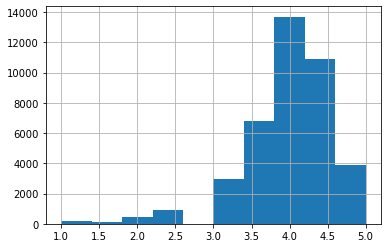

In [41]:
data['Rating'].hist(bins=10)

Распределение ранга городов

<AxesSubplot:>

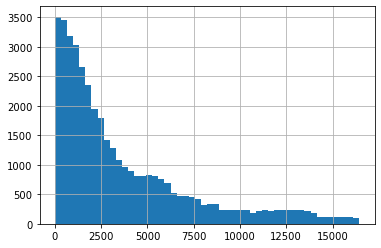

In [42]:
data['Ranking'].hist(bins=50)

Нормированное значение ранга городов

<AxesSubplot:>

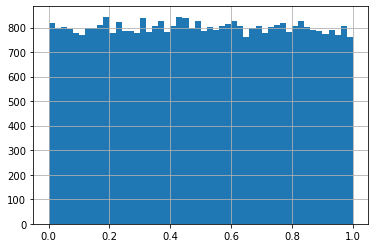

In [43]:
data['Normd city ranking'].hist(bins=50)

И распределение ресторанов по странам.

<AxesSubplot:>

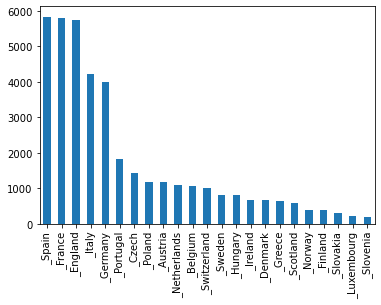

In [44]:
data['Country'].value_counts().plot(kind='bar')

Вывод по графикам: так сказать сходу, что я увидел, какой-то новый признак, аномалию или закономерность я не могу.

## Подготовим данные к обучению

Сначала уберем нечисловые столбцы и столбцы, ухудшающие финальный результат.

In [66]:
df = data.drop(['Restaurant_id', 'URL_TA', 'ID_TA', 'City', 'Cuisine Style', 'Price Range', 'Reviews', 'Cuisines list', 'Country', 'Prev review date', 'Recent review date', 'Number of Reviews', ], axis=1)

Проверим на пропуски

In [67]:
df = df.dropna()
df.shape

(40000, 196)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [68]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop('Rating', axis = 1)
y = df['Rating']

In [69]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [70]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [71]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [75]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [76]:
def rating_round(x, base=0.5):
    return base * round(x/base)

def predict(ds):
    return np.array([rating_round(x) for x in model.predict(ds)])

y_pred = predict(X_test)

y_pred1 = model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [77]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAE без округления:', metrics.mean_absolute_error(y_test, y_pred1))


MAE: 0.1784
MAE без округления: 0.20775499999999997


# Выводы

От начального показания MAE = 0.4 в результате работы с данными удалось достичь результата в MAE = 0.2. Для этого было проделаны следующие шаги:
 - Заполнены пропуски средними значениями, с целью минимизировать удаление пустых записей.
 - Были добавлены новые признаки, через обработку значений столбцов методом "apply" (кол-во представленных кухонь, население города).
 - Были добавлены новые признаки через 'get_dummies' (города, тип кухни, цена, страны).
 - Подобрал 3 признака, на которых применил PolynomialFeatures и сгенерировал дополнительные признаки. Получилось улучшить результат на 0.7
 - Посмотрел на таблицу корреляций. Но признаков сильно коррелирующих между собой не выявил.
 - Построил графики, с целью выявления аномалий. Выявлены не были.